# Multi-modal and Multi-Task Learning (MTL) Overview  

# Why Multi Task
Multi task learning helps in scenarios where there is a lot of general data, but very limited data for each class.
The example used in this notebook is predicting student test scores.
There are many students across the country and the data from each of them can be used to train a shared model.

However, only a handful of samples (~150) are available for each school.
Each school has distinct behavior in students that influences which factors are strong predictors of test scores.
By treating all students as part of the sam data set, we make it difficult for the model to adjust itself to the nuances of each school.

We can combat this by creating an artificial partition in the dataset on the school and giving each school a specific part of the model.
Situations such as these are where multi task learning is useful.

# Preface

##### A Common Source of Confusion

To aid in processing mutli-task learning for the first time it is helpful to reiterate the distinction between targets and tasks.
These two are *not* the same.
When switching from a traditional ML model to a multi-task model, it is still important to note that the target of the model is still to predict test scores.
The tasks are not pieces of output, but categories of data.

In summary: 
- Task: a breakpoint in the dataset that could be helpful to impart on the model before beginning training
- Target: the attribute the model is attempting to predict (same as traditional ML)

# MTL Summary
In Machine Learning, our traditional goal is to optimize for a specific target. 
We do this by training a model and refining it until the performance improvement flatlines. 
All of the data is processed in the same way.
By treating all the data as identical, we tend to leave out other pieces of potentially valuable information that could improve our score. 
In order to fix this, we present a Multi-Task Learning (MTL) approach.

MTL has been succesfully implemented and achieved increasingly better results than its single-task rival. Ranging from applications such as natural language processing (Collobert and Watson, 2008) to drug discovery (Ramsundar, et al., 2015), it has been shown to optimize most architectures if the dataset fits the situation. Although it is also known as joint learning, typically as soon as you start optimizing more than one loss function concurrently, you are considering to be multi-tasking. To give a more concise definition:

“MTL improves generalization by leveraging the domain-specific information contained in the training signals of related tasks". - [Caruana, 1998]

<img src="images/multi-task-graph.png" width="400">

An advantage to this type of model, is that while some of the hidden layers are shared among the data, they each have their own individual output layers, which greatly reduces the risk of overfitting. This is due to the model having a lot more data to learn from than it normally would.

By presenting a model with similar data but different goals, such as predicting scores of different schools around a country, we can make our overall performance better for our original task. Due to the split of data needed to train a multi-task model, one typically needs a very large, complete, and even dataset to train/test with.

## Multi Task Applications

In terms of specific applications, we will go down a history and talk about the ones we mentioned before:

NLP - Collobert and Watson 2008
Speech Recognition - Deng et al., 2013
Computer Vision - Girshick, 2015
Drug Discovery - Ramsundar et al., 2015 

https://arxiv.org/pdf/1707.08114.pdf
https://arxiv.org/pdf/1707.08114.pdf






## So why does MTL work?

### Implicit data augmentation
By having more than one task to train a model with, we passively acquire more data that has different noise patterns. For example, instead of overfitting on a single task A, we are able to learn with similar yet fundamentaly different task B, thus creating a more diverse and general representation.

### Attention focusing
If a task has a high amount of noise or the data is insufficient, a model can have issues solving which features are more relevent that others. However, with an MTL approach, features become easier to differentiate in terms of importance as the multitude of tasks will increase the amount of data available to test on.

### Eavesdropping
Similar to how some people are better at different individual tasks, so are models. Due to MTL, different models are able to "eavesdrop" on each other with shared layer, and spread the benefits of each to one another.

### Representation bias
MTL tends to prefer representations that the other tasks also focus on. This way, the model is better at generalizing new added tasks in the future and perform well on them if they are part of the same enviroment.

### Regularization
MTL acts as a passive regularizer by having an inductive bias (set of assumptions the learner uses to predict outputs), thus reducing the potential for overfitting and the overall Rademacher complexity of the model (the ability of it to fit random noise).


## Evaluation Regression: Bland-Altman plots
In order to evauluate our results, we will be using a Bland-Altman (Tukey mean-difference plot) graph to measure the agreeableness between the actual target values and our predicted target values. 

<img src="images/bland-altman.png" width="600">

Given two sets of data of n samples each, you plot them on a graph with the following equation:

$$S(x, y) = ( \dfrac{S_1 + S_2}{2} , S_1 - S_2 )$$

Your x-axis will be the mean of the numbers, and the y-axis will be the difference. The three lines on the graph represent the the mean +/- 2 Standard Deviations, creating a 95% confidence interval centered around our mean error.

The reason this graph is useful is because it helps mitigate errors from concluding that two pieces of data correlate with each other based solely on the correlation coefficient (least square fitting). Back in 1986, Bland and Altman showed that two sets of data can have a high correlation but not be in agreement at all. Plotting the data as a function of the mean vs the difference has proven a more accurate way to determine if two sets of data agree with each other, not just correlate. 

# School Data

## School Data Understanding

We will be using a UK school dataset comprised of 140 different school locations with a total of 15,000 students. Each student has 28 different features, each representing a demographic aspect (gender, age, etc).

To give a more detailed explanation of the data, this was taken from the data source itself:

Column    Description              Coding

     1         Year                     1985=1; 1986=2; 1987=3

     2-4       School                   Codes 1-139

     5-6       Exam Score               Numeric score

     7-8       % FSM                    Percent. students eligible for free
                                        school meals

     9-10      % VR1 band               Percent. students in school in VR band
                                        1

     11        Gender                   Male=0; Female=1

     12        VR band of student       VR1=2; VR2=3; VR3=1

     13-14     Ethnic group of          ESWI=1*; African=2; Arab=3;
               student                  Bangladeshi=4; Caribbean=5;
                                        Greek=6;Indian=7;Pakistani=8;
                                        S.E.Asian=9;Turkish=10; Other=11

                                        Mixed=1; Male=2; Female=3
     15        School gender
                                        Maintained=1; Church of
     16        School denomination      England=2; Roman Catholic=3

Originally there were only 16 features, but the categorical ones were replace with a binary feature for each possible value. In total, there were 27 plus the bias term. Each school is treated as an individual task and the exam score is the target.

In this notebooke will be exploring three different ways to create a classifier and compare their performances.
In the next few sections, we will be showing three different methods of completing the task on this data: 1) running each school through its own model, 2) running all the schools together into one model, 3) using a Multi-Task approach and having some of the layers shared by each school, and some individual.

## School Data Processing

In order to form tasks, we need to do a bit of preprocessing to get things into the correct format.

In [4]:
%matplotlib inline
import scipy.io
# from sklearn.datasets.base import Bunch
from sklearn.utils import Bunch
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# load the data for each individual school
school_indices = [scipy.io.loadmat('data/school_splits/school_%d_indexes.mat' % (x)) for x in range(1, 11)]
raw_data = scipy.io.loadmat('data/school_splits/school_b.mat')

In [5]:
# changed data to float because yhat will be floats
X = np.array(raw_data['x'].T)
y = np.array(raw_data['y'])
print("We have an input array of shape:", X.shape)
print("We have an output array of shape:", y.shape)

We have an input array of shape: (15362, 28)
We have an output array of shape: (15362, 1)


In [6]:
# normalize by each column and output array
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(y)

print(np.min(y), np.max(y))
print(np.max(X,axis=0))

-1.540494274135178 3.883416518311551
[ 1.45792115  1.55022259  1.26065324  3.30072644  2.98500084  0.96519332
  1.03606188  2.03500162  1.65680489  0.9276217   0.76176774  6.45540256
 14.47198522  7.59167885  2.15202966  8.66311174  6.11596272  8.05799792
  8.22072729  7.56236695  4.02047831  1.05034809  1.79001671  1.57740057
  0.73278133  2.5547412   1.9023042   0.        ]


In [7]:
# Matlab - arrays are indexed at 1, needs adapting
start_index = np.ravel(raw_data["task_indexes"] - 1)

In [8]:
# save each school data into a separate dictionary key
# value is a bunch with both feature data and labels
tasks = dict()
for i in range(len(start_index)):
    start = start_index[i]
    if i == len(start_index) - 1:
        end = -1
    else:
        end = start_index[i + 1]
    descr = "School data: school {}".format(i + 1)
    sid = "School {}".format(i + 1)
    tasks[sid] = Bunch(data=X[start:end],
                       target=y[start:end],
                       DESCR=descr)
#     if len(tasks.keys())>50:
#         break

In [9]:
print("Number of schools in dataset:", len(tasks.keys()))

Number of schools in dataset: 139


15361


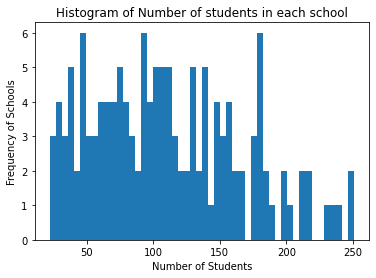

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

examples = [len(tasks[key].data) for key in tasks.keys()]

print(np.sum(examples))
plt.hist(examples, bins=50)
plt.title('Histogram of Number of students in each school')
plt.xlabel('Number of Students')
plt.ylabel('Frequency of Schools')
plt.show()

In [11]:

from sklearn.metrics import mean_squared_error, accuracy_score 
from sklearn.metrics import precision_score, mean_squared_log_error

def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    
    plt.figure(figsize=(15,10))
    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
    plt.title("Bland Altman, MSE: "+str(mean_squared_error(data1,data2)))
    plt.xlabel('Mean Score', fontsize=8)
    plt.ylabel('Diff Score', fontsize=8)
    plt.show()

____
## Independent School Models

First, let's train each school on its own individual model.
Each of the 141 models will only have an average of 107.4 data points between both train and test data.

In [12]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten

In [13]:
# create training and testing data
# for each task
X_train = dict()
y_train = dict()
X_test = dict()
y_test = dict()

for x in tasks.keys():
    X_train[x], X_test[x], y_train[x], y_test[x] = train_test_split(tasks[x].data, 
                                                        tasks[x].target, 
                                                        test_size=0.4, 
                                                        random_state=42)

In [14]:
%%time

y_ind=[]
yhat_ind=[]

for x in tasks.keys():
    #X_train = x.data
    #y_train = x.target
    # train model on one school
    print(x,end=', ')

    mlp = Sequential()
    mlp.add(Dense(input_dim=X_train[x].shape[1], units=30, activation='relu'))
    mlp.add( Dense(units=15, activation='relu') )
    mlp.add(Dense(1))

    mlp.compile(loss='mean_squared_error',
                optimizer='rmsprop',
                metrics=[])
    
    mlp.fit(X_train[x], y_train[x], epochs=5, shuffle=True, verbose=0)
    
    # save the output results
    yhat_mlp = mlp.predict(X_test[x])

    
    y_ind.append(y_test[x].ravel())
    yhat_ind.append(yhat_mlp.ravel())



School 1, School 2, School 3, School 4, School 5, School 6, School 7, School 8, School 9, School 10, School 11, School 12, School 13, School 14, School 15, School 16, School 17, School 18, School 19, School 20, School 21, School 22, School 23, School 24, School 25, School 26, School 27, School 28, School 29, School 30, School 31, School 32, School 33, School 34, School 35, School 36, School 37, School 38, School 39, School 40, School 41, School 42, School 43, School 44, School 45, School 46, School 47, School 48, School 49, School 50, School 51, School 52, School 53, School 54, School 55, School 56, School 57, School 58, School 59, School 60, School 61, School 62, School 63, School 64, School 65, School 66, School 67, School 68, School 69, School 70, School 71, School 72, School 73, School 74, School 75, School 76, School 77, School 78, School 79, School 80, School 81, School 82, School 83, School 84, School 85, School 86, School 87, School 88, School 89, School 90, School 91, School 9

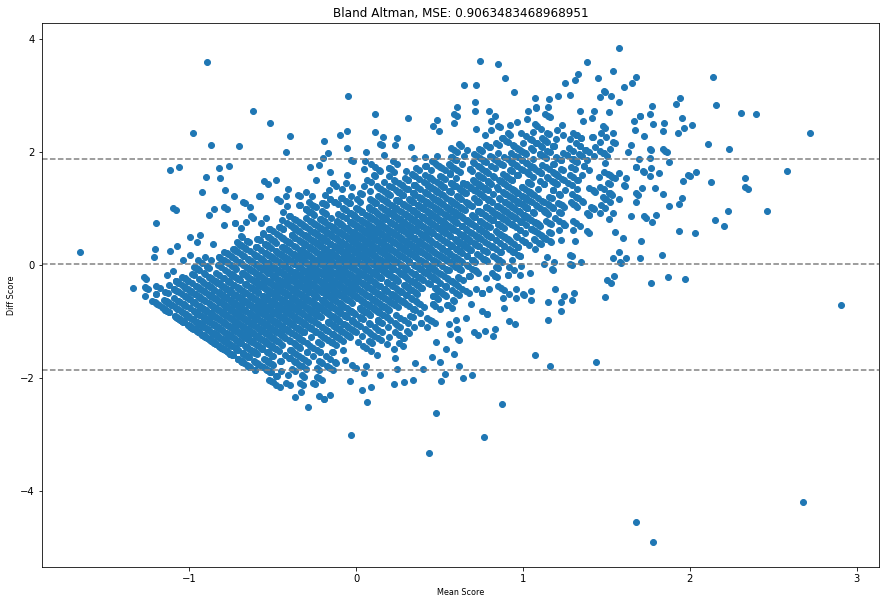

In [15]:
# concatenate results and take bland-altman output result
bland_altman_plot(np.concatenate(y_ind), 
                  np.concatenate(yhat_ind))

This graph is a Bland Altman plot, indended to show the relationship between two sets of values by plotting the difference between them on the y-axis and the average of them on the x-axis. This way, you can see the residual difference between our predictions and the actual numbers. 
   
Each dot size represents its group standard deviation, the larger it is, the larger the STD is. In addition, each dot represents a different school, with each point being the average of all the points for that category.  

## General School Model

Let's see if using a single model for all the schools increases our accuracy.  We will have one model with all 15000 training instances.

In [16]:
# create a split of the data, cross validated with stratification 
#  across the schools
all_data = {"data": [], "target": [], "data_test": [], "target_test": []}
for x in tasks.keys():
    all_data["data"].append(X_train[x])
    all_data["target"].append(y_train[x])        
    all_data["data_test"].append(X_test[x])
    all_data["target_test"].append(y_test[x])

# now concatenate these into one big vector, stratified
X_train_all = np.concatenate(all_data["data"])
y_train_all = np.concatenate(all_data["target"])

X_test_all = np.concatenate(all_data["data_test"])
y_test_all = np.concatenate(all_data["target_test"])

In [17]:
generalized_mlp = Sequential()
generalized_mlp.add(Dense(input_dim=X_train_all.shape[1], units=32, activation='relu', name='input_dense32'))
generalized_mlp.add(Dense(units=16, activation='relu', name='mid_dense16'))
generalized_mlp.add(Dense(1, activation='linear', name='output_layer'))

generalized_mlp.compile(loss='mean_squared_error',
            optimizer='rmsprop',
            metrics=[])

generalized_mlp.fit(X_train_all, y_train_all, epochs=20, 
                    shuffle=True, verbose=1, validation_data=(X_test_all,y_test_all))
y_hat_general = generalized_mlp.predict(X_test_all)

Train on 9169 samples, validate on 6192 samples
Epoch 1/20
9169/9169 [==============================] - 1s 135us/sample - loss: 0.8328 - val_loss: 0.6934
Epoch 2/20
9169/9169 [==============================] - 1s 63us/sample - loss: 0.6702 - val_loss: 0.6808
Epoch 3/20
9169/9169 [==============================] - 1s 66us/sample - loss: 0.6556 - val_loss: 0.6774
Epoch 4/20
9169/9169 [==============================] - 1s 71us/sample - loss: 0.6484 - val_loss: 0.6741
Epoch 5/20
9169/9169 [==============================] - 1s 68us/sample - loss: 0.6432 - val_loss: 0.6680
Epoch 6/20
9169/9169 [==============================] - 1s 70us/sample - loss: 0.6383 - val_loss: 0.6749
Epoch 7/20
9169/9169 [==============================] - 1s 85us/sample - loss: 0.6345 - val_loss: 0.6656
Epoch 8/20
9169/9169 [==============================] - 1s 94us/sample - loss: 0.6325 - val_loss: 0.6673
Epoch 9/20
9169/9169 [==============================] - 1s 72us/sample - loss: 0.6298 - val_loss: 0.6648
Epoch 

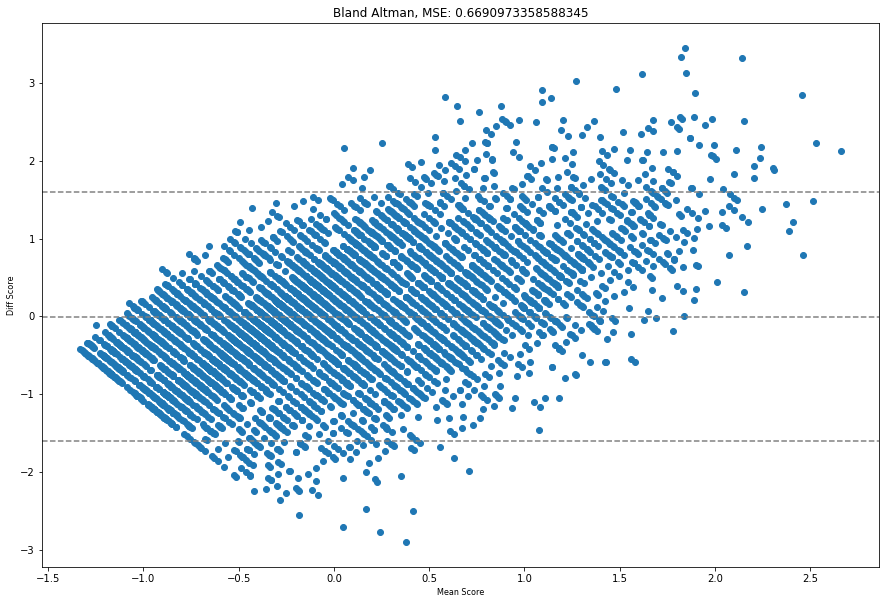

In [18]:
bland_altman_plot(y_test_all, y_hat_general)

## School Multi-Task Model
Create a multi task model that learns from all schools at the same time.

In [19]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

#get weights of generalized model
w1 = generalized_mlp.get_layer('input_dense32').get_weights()
w2 = generalized_mlp.get_layer('mid_dense16').get_weights()
w_output = generalized_mlp.get_layer('output_layer').get_weights()

# set these weights
inputs = Input(shape=(X_train_all.shape[1],))
shared_input = Dense(32, activation='relu', name = 'shared_input', trainable=False)(inputs)
shared_mlp = Dense(16, activation='relu', name = 'shared_middle', trainable=False)(shared_input)

# make a dictionary of models for each task
models_mtl = dict()

for x in tasks.keys():
    # use same architecture as the general model, but 
    #. repeat the output layer such that  
    output_layer = Dense(1, activation='linear')(shared_mlp)
    model = Model(inputs=inputs, outputs=output_layer)
    model.compile(optimizer='rmsprop', loss='mean_squared_error')
    models_mtl[x] = model
    
    shared1 = models_mtl[x].get_layer('shared_input')
    shared2 = models_mtl[x].get_layer('shared_middle')
    personal = models_mtl[x].layers[-1]
    # set to be the weights from the general model, as starting point
    shared1.set_weights(w1) 
    shared2.set_weights(w2)
    personal.set_weights(w_output)
    shared1.trainable = False
    shared2.trainable = False
    personal.trainable = True
    
    

In [20]:
%%time
EPOCHS = 20
from random import shuffle

all_keys = list(tasks.keys())
for i in range(EPOCHS):
    print('Epoch',i,end=', ')
    shuffle(all_keys) # shuffle in place operation
    y_mtl=[]
    yhat_mtl=[]
    for x in all_keys:
        # train the personalized layers ONLY
        # no need to worry about fitting too much to one school
        # because shared layers are not updated
        models_mtl[x].fit(X_train[x],y_train[x], 
                          verbose=0, 
                          epochs=1, 
                          shuffle=True)
        # test on some data
        yhat_mlp = models_mtl[x].predict(X_test[x])
        y_mtl.append(y_test[x].ravel())
        yhat_mtl.append(yhat_mlp.ravel())
        
    mse = mean_squared_error(np.concatenate(y_mtl), np.concatenate(yhat_mtl))
    print('...MSE Validation:',mse)

Epoch 0, ...MSE Validation: 0.6649029926372829
Epoch 1, ...MSE Validation: 0.6627445500882005
Epoch 2, ...MSE Validation: 0.6612359472966289
Epoch 3, ...MSE Validation: 0.6598112918663065
Epoch 4, ...MSE Validation: 0.6587773492200379
Epoch 5, ...MSE Validation: 0.6578415854977527
Epoch 6, ...MSE Validation: 0.6570536564938155
Epoch 7, ...MSE Validation: 0.6562375607693709
Epoch 8, ...MSE Validation: 0.655593532521671
Epoch 9, ...MSE Validation: 0.6549490999796722
Epoch 10, ...MSE Validation: 0.6543815507693468
Epoch 11, ...MSE Validation: 0.6539267919149487
Epoch 12, ...MSE Validation: 0.6534147824435124
Epoch 13, ...MSE Validation: 0.653071707783584
Epoch 14, ...MSE Validation: 0.6525709344881281
Epoch 15, ...MSE Validation: 0.6522448393376563
Epoch 16, ...MSE Validation: 0.6519727196204435
Epoch 17, ...MSE Validation: 0.6516778753294685
Epoch 18, ...MSE Validation: 0.6513399894690179
Epoch 19, ...MSE Validation: 0.6511335186951854
CPU times: user 6min 10s, sys: 24.1 s, total: 6min 3


## Fine tuning the multi-task model
Now let's see if we can make the model even better through fine tuning the base model.

In [21]:
%%time

layer1 = models_mtl[x].get_layer('shared_input')
layer2 = models_mtl[x].get_layer('shared_middle')

# now do some fine tuning
layer1.trainable = False
layer2.trainable = True

EPOCHS = 5

all_keys = list(tasks.keys())
for i in range(EPOCHS):
    print('Epoch',i,end=', ')
    shuffle(all_keys) # shuffle in place operation
    y_mtl=[]
    yhat_mtl=[]
    for x in all_keys:
        # becasue we are updating the shared layers now, we 
        #. should be careful not to use too much of one school's data
        #. in a single epoch. So we use the "steps_per_epoch" param.
        models_mtl[x].fit(X_train[x],y_train[x], 
                          verbose=0, 
                          batch_size=8,
                          epochs=1,
                          steps_per_epoch=2, 
                          shuffle=True)
        # test on some data
        yhat_mlp = models_mtl[x].predict(X_test[x])
        y_mtl.append(y_test[x].ravel())
        yhat_mtl.append(yhat_mlp.ravel())
        
    mse = mean_squared_error(np.concatenate(y_mtl), np.concatenate(yhat_mtl))
    print('...MSE Validation:',mse)

Epoch 0, ...MSE Validation: 0.6507560028386198
Epoch 1, ...MSE Validation: 0.6505523559662958
Epoch 2, ...MSE Validation: 0.6505415525892266
Epoch 3, ...MSE Validation: 0.6507031196639658
Epoch 4, ...MSE Validation: 0.6508301480659947
CPU times: user 1min 25s, sys: 5.7 s, total: 1min 30s
Wall time: 1min 22s


In [22]:
%%time

layer1 = models_mtl[x].get_layer('shared_input')
layer2 = models_mtl[x].get_layer('shared_middle')

# now do some fine tuning
layer1.trainable = True
layer2.trainable = True

EPOCHS = 20

all_keys = list(tasks.keys())
for i in range(EPOCHS):
    print('Epoch',i,end=', ')
    shuffle(all_keys) # shuffle in place operation
    y_mtl=[]
    yhat_mtl=[]
    for x in all_keys:
        models_mtl[x].fit(X_train[x],y_train[x], 
                          verbose=0, 
                          batch_size=8,
                          epochs=1,
                          steps_per_epoch=2, 
                          shuffle=True)
        # test on some data
        yhat_mlp = models_mtl[x].predict(X_test[x])
        y_mtl.append(y_test[x].ravel())
        yhat_mtl.append(yhat_mlp.ravel())
        
    mse = mean_squared_error(np.concatenate(y_mtl), np.concatenate(yhat_mtl))
    print('...MSE Validation:',mse)

Epoch 0, ...MSE Validation: 0.6507773913940273
Epoch 1, ...MSE Validation: 0.6507235366665776
Epoch 2, ...MSE Validation: 0.6507612455880627
Epoch 3, ...MSE Validation: 0.6508224293295979
Epoch 4, ...MSE Validation: 0.6507791918904392
Epoch 5, ...MSE Validation: 0.6506910471080972
Epoch 6, ...MSE Validation: 0.6506153791285676
Epoch 7, ...MSE Validation: 0.6505968604355549
Epoch 8, ...MSE Validation: 0.6504838043876638
Epoch 9, ...MSE Validation: 0.6502996802008669
Epoch 10, ...MSE Validation: 0.6500839879312772
Epoch 11, ...MSE Validation: 0.6500900503468453
Epoch 12, ...MSE Validation: 0.6499202931480644
Epoch 13, ...MSE Validation: 0.6496366676933827
Epoch 14, ...MSE Validation: 0.6496797077580433
Epoch 15, ...MSE Validation: 0.6496730150406261
Epoch 16, ...MSE Validation: 0.6495599635587284
Epoch 17, ...MSE Validation: 0.6494274672109059
Epoch 18, ...MSE Validation: 0.6492278998555339
Epoch 19, ...MSE Validation: 0.6491399678252439
CPU times: user 5min 3s, sys: 21.4 s, total: 5min 

In [23]:
%%time
y_mtl=[]
yhat_mtl=[]

for x in X_test.keys():
    yhat_mlp = models_mtl[x].predict(X_test[x])

    y_mtl.append(y_test[x].ravel())
    yhat_mtl.append(yhat_mlp.ravel())

CPU times: user 6.6 s, sys: 496 ms, total: 7.1 s
Wall time: 6.31 s


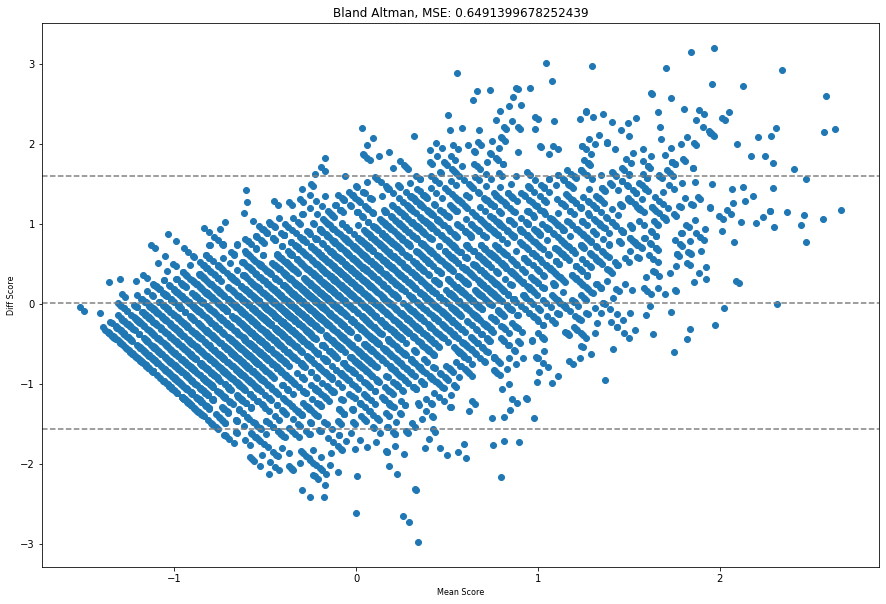

In [24]:
bland_altman_plot(np.concatenate(y_mtl), np.concatenate(yhat_mtl))

___
# Computer Survey Data

### Computer Survey Data Understanding
This data set was obtained on pmtkdata project's web site:
    https://code.google.com/p/pmtkdata/.
It was used by "Argyriou, Evgeniou, Pontil - Convex multi-task feature learning - ML 2008" and "Kumar, Daume III - Learning Task Grouping and Overlap in Multi-Task Learning - ICML 2012".

The data set's properties are:
   
20 samples (all subjects have the same samples)
13 features (describing computer's intrinsic (e.g. CPU speed, RAM) and extrinsic (e.g. Hot line support, Color of unit) features)
regression task of predicting subject's likelihood of purchasing a personal computer
   
Each data point is 20 x 14, which is each of the computers for that respective student. The computers are the students and the students are the school while the ratings are the test scores and the comp specs are the demographs.

In [126]:
%matplotlib inline
import os.path
import scipy.io
from sklearn.datasets.base import Bunch
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

def load_computer_survey_data():
    """
    Returns
    -------
    tasks -- list
        A list of Bunch objects that correspond to regression tasks, each task
        corresponding to one subject.
    """
    
    #matlab_file = os.path.join("data/data/computer/conjointAnalysisComputerBuyers.mat")
    mat = scipy.io.loadmat("data/computer/conjointAnalysisComputerBuyers.mat")
    # feature names are taken from the ComputerSurveyFull.xls file, Sheet named
    # Design Matrix
    feature_names = ["cnst", "Hot line", "RAM", "Screen size", "CPU speed",
                     "Hard disk", "CD ROM", "Cache", "Color of unit",
                     "Availability", "Warranty", "Software", "Guarantee",
                     "Price"]
    # extract X and combined y data
    X = mat["designMarix"].astype("float")
    y_combined = mat["likeBuy"].astype("float")
    # create a task for each subject
    tasks = dict()
    for subject in range(len(y_combined)):
        descr = "Computer Survey data: Subject {}".format(subject)
        cid = "Subject{}".format(subject)
        y = np.array(y_combined[subject], copy=True)
        tasks[cid] = Bunch(data=X,
                           target=y.reshape(20, 1),
                           feature_names=feature_names,
                           DESCR=descr)
    return tasks

In [150]:
comp_tasks = load_computer_survey_data()
print(len(comp_tasks.keys()), 'Tasks')
task = comp_tasks[list(comp_tasks.keys())[0]]
print(task.data.shape)

num_instances = sum([len(comp_tasks[x].data) for x in comp_tasks.keys()])

print(num_instances)

190 Tasks
(20, 14)
3800


## Individual Computer Model

In [128]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, mean_squared_log_error

In [151]:
%%time 
yc_ind=[]
yhatc_ind=[]

for x in comp_tasks.keys():
    print(x,end=',')
    X_train, X_test, y_train, y_test = train_test_split(comp_tasks[x].data, 
                                                        comp_tasks[x].target, 
                                                        test_size=0.25, 
                                                        random_state=42)

    mlp = Sequential()
    mlp.add(Dense(input_dim=X_train.shape[1], units=30, activation='relu'))
    mlp.add( Dense(units=15, activation='relu') )
    mlp.add(Dense(1))

    mlp.compile(loss='mean_squared_error',
                optimizer='rmsprop',
                metrics=[])
    
    mlp.fit(X_train, y_train, epochs=10, shuffle=True, verbose=0)
    
    yhat_mlp = mlp.predict(X_test)
    
    yc_ind.append(y_test.ravel())
    yhatc_ind.append(yhat_mlp.ravel())
    

Subject0,Subject1,Subject2,Subject3,Subject4,Subject5,Subject6,Subject7,Subject8,Subject9,Subject10,Subject11,Subject12,Subject13,Subject14,Subject15,Subject16,Subject17,Subject18,Subject19,Subject20,Subject21,Subject22,Subject23,Subject24,Subject25,Subject26,Subject27,Subject28,Subject29,Subject30,Subject31,Subject32,Subject33,Subject34,Subject35,Subject36,Subject37,Subject38,Subject39,Subject40,Subject41,Subject42,Subject43,Subject44,Subject45,Subject46,Subject47,Subject48,Subject49,Subject50,Subject51,Subject52,Subject53,Subject54,Subject55,Subject56,Subject57,Subject58,Subject59,Subject60,Subject61,Subject62,Subject63,Subject64,Subject65,Subject66,Subject67,Subject68,Subject69,Subject70,Subject71,Subject72,Subject73,Subject74,Subject75,Subject76,Subject77,Subject78,Subject79,Subject80,Subject81,Subject82,Subject83,Subject84,Subject85,Subject86,Subject87,Subject88,Subject89,Subject90,Subject91,Subject92,Subject93,Subject94,Subject95,Subject96,Subject97,Subject98,Subject99,Subject100

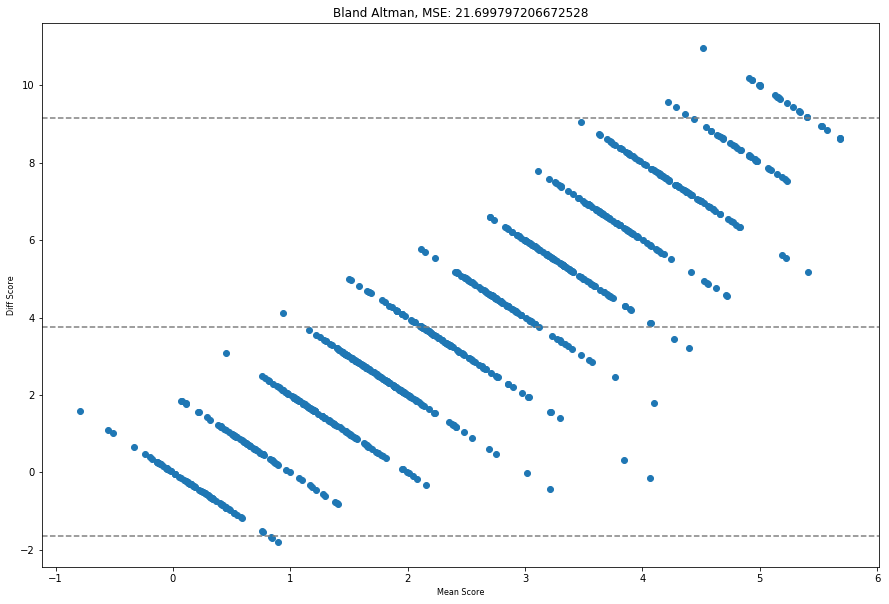

In [152]:
bland_altman_plot(np.concatenate(yc_ind), 
                  np.concatenate(yhatc_ind))

## General Computer Model

In [142]:
all_comp_data = {"data": [], "target": [], "data_test": [], "target_test": []}
for x in comp_tasks.keys():
    X_train, X_test, y_train, y_test = train_test_split(comp_tasks[x].data, 
                                                        comp_tasks[x].target, test_size=0.25, random_state=42)
    all_comp_data["data"].append(X_train)
    all_comp_data["target"].append(y_train)        
    all_comp_data["data_test"].append(X_test)
    all_comp_data["target_test"].append(y_test)

X_train_comp = np.concatenate(all_comp_data["data"])
X_test_comp  = np.concatenate(all_comp_data["data_test"])
y_train_comp = np.concatenate(all_comp_data["target"])
y_test = np.concatenate(all_comp_data["target_test"])

In [143]:
generalizedc_mlp = Sequential()
generalizedc_mlp.add(Dense(input_dim=X_train_comp.shape[1], units=20, activation='relu'))
generalizedc_mlp.add(Dense(units=10, activation='relu'))
generalizedc_mlp.add(Dense(1))

generalizedc_mlp.compile(loss='mean_squared_error',
            optimizer='rmsprop',
            metrics=[])

generalizedc_mlp.fit(X_train_comp, y_train_comp, epochs=20, shuffle=True, verbose=1)

yhat_general = generalizedc_mlp.predict(X_test_comp)

Epoch 1/20
2850/2850 [==============================] - 30s 11ms/step - loss: 21.9476
Epoch 2/20
2850/2850 [==============================] - 1s 468us/step - loss: 8.3594
Epoch 3/20
2850/2850 [==============================] - 1s 452us/step - loss: 6.1737
Epoch 4/20
2850/2850 [==============================] - 1s 454us/step - loss: 6.0707
Epoch 5/20
2850/2850 [==============================] - 1s 455us/step - loss: 6.0609
Epoch 6/20
2850/2850 [==============================] - 1s 453us/step - loss: 6.0626
Epoch 7/20
2850/2850 [==============================] - 1s 460us/step - loss: 6.0463
Epoch 8/20
2850/2850 [==============================] - 1s 456us/step - loss: 6.0618
Epoch 9/20
2850/2850 [==============================] - 1s 459us/step - loss: 6.0607
Epoch 10/20
2850/2850 [==============================] - 1s 455us/step - loss: 6.0547
Epoch 11/20
2850/2850 [==============================] - 1s 458us/step - loss: 6.0548
Epoch 12/20
2850/2850 [==============================] - 1s 45

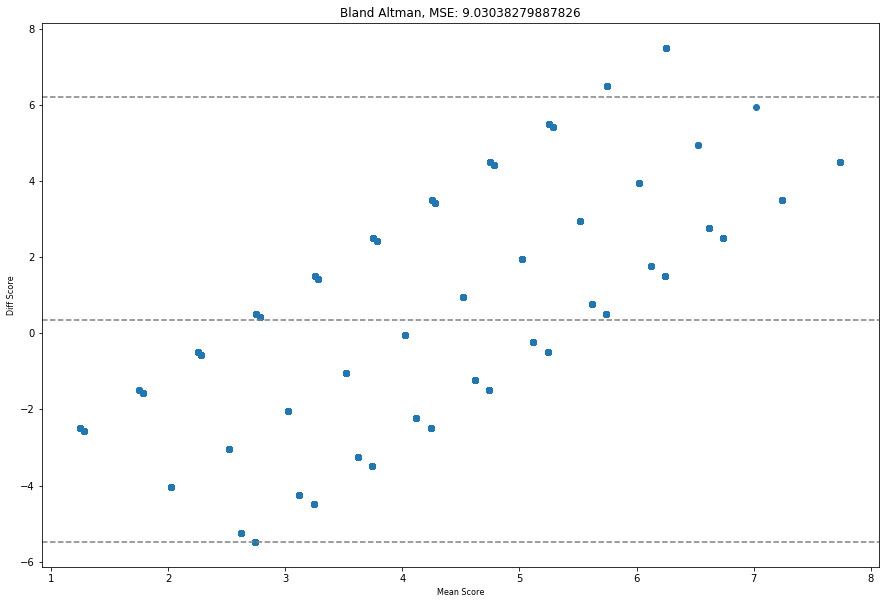

In [144]:
bland_altman_plot(y_test, yhat_general)

## Computer Survey Multi-Task Model

In [145]:
from keras.layers import Input, Dense
from keras.models import Model

inputs = Input(shape=(X_train_comp.shape[1],))
shared_mlp = Dense(64, activation='relu')(inputs)
shared_mlp = Dense(64, activation='relu')(shared_mlp)

models_mtl = dict()

for x in comp_tasks.keys():
    personal_layer = Dense(10, activation='relu')(shared_mlp)
    output_layer = Dense(1)(personal_layer)
    model = Model(inputs=inputs, outputs=output_layer)
    model.compile(optimizer='sgd', loss='mean_squared_error')
    models_mtl[x] = model

In [146]:
X_train = dict()
y_train = dict()
X_test = dict()
y_test = dict()

for x in comp_tasks.keys():
    X_train[x], X_test[x], y_train[x], y_test[x] = train_test_split(comp_tasks[x].data, 
                                                        comp_tasks[x].target, 
                                                        test_size=0.25, random_state=42)
    

In [147]:
%%time
EPOCHS = 5
from random import shuffle

all_keys = list(X_train.keys())
for i in range(EPOCHS):
    print('Epoch',i,end=', ')
    shuffle(all_keys)
    for x in all_keys:
        # during firsth iteration, this will take a while as 
        #  the computation graph is initialized and run
        #  after this, the run time should be considerably reduced
        models_mtl[x].fit(X_train[x],y_train[x], verbose=0, 
                          batch_size=8,
                          epochs=1,
                          steps_per_epoch=2, 
                          shuffle=True)

Epoch 0, Epoch 1, Epoch 2, Epoch 3, Epoch 4, CPU times: user 1h 36min 49s, sys: 1min 2s, total: 1h 37min 52s
Wall time: 1h 38min 31s


In [148]:
%%time
y_mtl=[]
yhat_mtl=[]

for x in X_test.keys():
    yhat_mlp = models_mtl[x].predict(X_test[x])

    y_mtl.append(y_test[x].ravel())
    yhat_mtl.append(yhat_mlp.ravel())

CPU times: user 48min 38s, sys: 19.5 s, total: 48min 58s
Wall time: 49min 21s


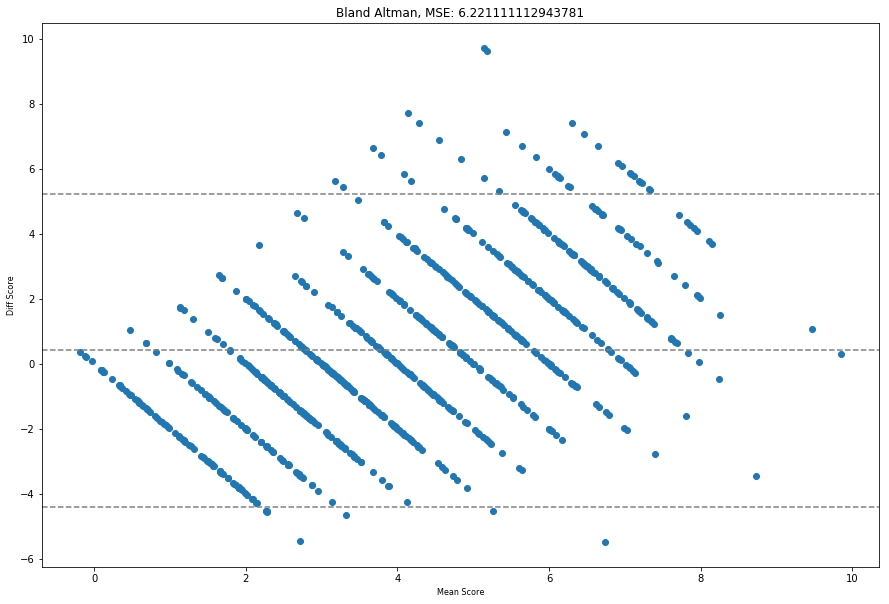

In [149]:
bland_altman_plot(np.concatenate(y_mtl), 
                  np.concatenate(yhat_mtl) )


# Multi-modal Summary
A multi-modal design can be defined as a system designed to fufill one task based on a variety of similar input. The reason for this design is due to the many advantages it offers in the right situations. For example, in the medical field, a doctor uses multiple image data (such as a CT, MRI, ultrasound, etc) in order to be able to diagnose a patient more effectively. 
   
There are a varierty of ways one can go about combining similar data together to be used. Early fusion is when the different data sources are combined together in the pre-processing phase through either PCA, ICA, or CCA and then presented to the machine learning algorithm to be processed. Later on, late fusion became the norm as ensemble classifiers became more and more popular. This method was typically easier and better to implement, especially if the different inputs varied significantly. However, recently, Deep Neural Network Architectures have paved a way for a third type, Indermediate fusion, a method of merging the modality throughout the many hidden layers and connecting the data on a very abstract, yet effective, level.
<img src="images/multi-modal-graph.png" width="700">

## References
Image #1: http://stanford.edu/~eadeli/

Image #2: http://ruder.io/multi-task/

Bland-Altman picture & info : https://en.wikipedia.org/wiki/Bland%E2%80%93Altman_plot

Source: https://keras.io/getting-started/functional-api-guide/#multi-input-and-multi-output-models

Bland Altman: https://en.wikipedia.org/wiki/Bland%E2%80%93Altman_plot

School Papers:

Overview of Multi-Task Learning: https://arxiv.org/pdf/1706.05098.pdf

Multi-modal Learning: https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8103116
   
2015 https://www.ijcai.org/Proceedings/15/Papers/512.pdf
   
2017 https://arxiv.org/pdf/1703.00977.pdf

2017 https://arxiv.org/pdf/1611.03427.pdf

data import: https://github.com/tjanez/PyMTL/blob/master/src/PyMTL/data.py

In [ ]:
import pandas, numpy

def cleanUp(filename, BA='IC50', UNITS='nM'):
   # Read in the file.
   d = pandas.read_table(filename, sep=r',(?=(?:[^"]*"[^"]*")*[^"]*$)', engine='python')

   # Eliminate duplicates.
   #d =d.drop_duplicates(['ACTIVITY_ID'])

   # Retain only IC50 entries
   # (do not mess with the conversion -- like, from logIC50 or pIC50 to IC50 -- as the fraction of
   # those entries is negligible).
   d = d[d.STANDARD_TYPE==BA]

   # Restrict to exclusively human targets
   # (this will take care of unwanted 'Starlite ...' entries as well).
   #d = d[d.NAME.str.startswith('h')]

   # Retain only the nM entries.
   d = d[d.STANDARD_UNITS==UNITS]

   # Integerize the DOM_ID column (the COMPOUND_ID column type is already 'int').
   d.DOC_ID = d.DOC_ID.astype(int)

   # Delete idle columns.
   #d.drop([Column Name or list],inplace=True,axis=1)

   return d

def binarizeInteractions(d, MIN=100, MAX=10000):
   # Apply the interaction criterion.
   ci = d[((d.STANDARD_RELATION=='=') | (d.STANDARD_RELATION=='~') | (d.STANDARD_RELATION=='<') | (d.STANDARD_RELATION=='<=')) & (d.STANDARD_VALUE<=MIN)]
   # Apply the non-interaction criterion.
   no = d[((d.STANDARD_RELATION=='=') | (d.STANDARD_RELATION=='~') | (d.STANDARD_RELATION=='>') | (d.STANDARD_RELATION=='>>') | (d.STANDARD_RELATION=='>=')) & (d.STANDARD_VALUE>=MAX)]
   print("Look up how to suppress the warning message below.")
   ci.STANDARD_VALUE = 1
   no.STANDARD_VALUE = 0
   return pandas.concat([ci, no])

d = cleanUp("generated_data/molecules.csv")
cino = binarizeInteractions(d)
# Remove entries with less than 50 ligands per target.
cino = cino.groupby('MOLGREGNO').filter(lambda x: len(x) > 49)

dom_ID = numpy.unique( cino.DOC_ID.value_counts().index )
com_ID = numpy.unique( cino.RECORD_ID.value_counts().index )
print (com_ID.size, dom_ID.size)

# Initialize the target-compound matrix.
ma = pandas.DataFrame( numpy.nan*numpy.ones((com_ID.size, dom_ID.size)), columns=dom_ID, index=com_ID )
# Fill in the target-compound matrix and save it as a file.
for i, r in cino.iterrows():
   ma[r.DOC_ID][r.RECORD_ID] = r.STANDARD_VALUE
ma.to_csv("ChemBL/kinda_works.csv")

#d = pandas.read_csv('ChemBL/kinda_works.csv')
#d.columns = d.columns.astype(int)

In [ ]:
from __future__ import print_function

from rdkit import Chem
from rdkit.Chem import MACCSkeys, AllChem
from rdkit.Avalon import pyAvalonTools as fpAvalon
from rdkit.Chem.AtomPairs import Pairs, Torsions
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem.ChemicalFeatures import BuildFeatureFactory
from rdkit.Chem import rdMolDescriptors
import pandas as pd
import argparse
import textwrap
import getopt
from argparse import ArgumentParser
import time

def CalculateFP_mod(smiles, N_BITS=512):
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        raise ValueError('SMILES cannot be converted to a RDKit molecules:', smiles)

    return AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=N_BITS)


if __name__ == "__main__":
    parser = ArgumentParser()

    parser.add_argument("-i", "--input", dest="ligandsWithSmiles", required=True,help="expected file containing 2 cols molregno,smiles", metavar="FILE")

    parser.add_argument("-s", "--size", dest="numBits", default=512,help="Size of fingerprints",metavar="NumBits")



    args = parser.parse_args()

    print ( "reading from file   %s" %(args.ligandsWithSmiles))

    ipFile = args.ligandsWithSmiles

    df = pd.read_csv(ipFile)



    numBits = int(args.numBits)
    count = 0
    errorCompounds = []



    current_milli_time = lambda: int(round(time.time() * 1000))

    opFile = "ChemBL/CompoundFingerPrints_%d_%s.csv"%(numBits,current_milli_time())

    print("Generating output file with fingerprints %s"%opFile)
    with open(opFile,"w") as fpFile :

        tempLine = ""

        tempLine ="molregno"
        for i in range(0,numBits):
            tempLine=tempLine+","+"Compound_"+str(i)
        fpFile.writelines(tempLine+"\n")

        tempLine = ""

        for row in df.iterrows():
            mol= row[1][0]
            smilesCode= row[1][1]

            try:
                count = count + 1
                tempLine = str(mol)

                temp = CalculateFP_mod(smilesCode)
                strFP = temp.ToBitString()

                for i in range(0,len(strFP)):
                    tempLine=tempLine+","+strFP[i]


                fpFile.writelines(tempLine+"\n")

                if count%100000 ==0 :
                    print(count)
            except :
                errorCompounds.append(mol)


    print("Generating error.log for failed compounds")
    with open("ChemBL/error.log","w") as fp :
        fp.write("Following compounds errored out \n")
        fp.write(str(errorCompounds))
